In [1]:
import numpy as np
from os import listdir, getcwd
from os.path import isfile, join
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_and_save_train_data(datapath, output_file):
    '''Gets train instances and save '''
    commands_dirs_by_readers = [join(datapath,f) for f in listdir(datapath) if not isfile(join(datapath, f))]
    instances = np.concatenate([np.concatenate([get_mfc_file(join(join(directory, 'komutlar'), f))]) for directory in commands_dirs_by_readers for f in listdir(join(directory, 'komutlar')) if f.endswith('.mfc')])
    np.save(output_file, instances)
    return instances

In [3]:
def load_datapoints(filepath):
    return np.load(filepath)

In [4]:
def get_mfc_file(path):
    '''Loads mfc file as matrix'''
    return np.loadtxt(path)


In [5]:
def get_and_save_test_data(datapath, output_file):
    '''Gets and saves test instances'''
    test_instances = np.concatenate([np.concatenate([get_mfc_file(join(datapath,f))]) for f in listdir(datapath) if f.endswith('.mfc')])
    np.save(output_file, test_instances)
    return test_instances

In [8]:
def find_cluster(point, centroids):
    dist_to_centroids = []   
    for centroid in centroids:
        dist = distance(point, centroid)
        dist_to_centroids.append(dist)
    return [i for i in sorted(enumerate(dist_to_centroids), key=lambda x:x[1])][0]

In [9]:
def distance(point1, point2):
    return np.linalg.norm(point1-point2, ord=2)

In [10]:
def cluster_distortion(cluster, centroid):
    return sum([distance(point, centroid) for point in cluster])

In [11]:
def total_distortion(clusters):
    return sum([cluster_distortion(points, centroid) for centroid, points in clusters])

In [12]:
def kmeans_clustering(points, number_of_clusters):
    centroid_indices = random.sample(range(len(points)), number_of_clusters)
    centroids = [points[index] for index in centroid_indices]
    clusters = [[] for i in range(number_of_clusters)]
    terminate = False
    last_distortion = total_distortion([(np.matrix(points).mean(0), points)])       
    while terminate == False:
        clusters = [[] for i in range(number_of_clusters)]
        for point in points:
            dist_to_centroids = [distance(point, centroid) for centroid in centroids]
            cluster_index = [i[0] for i in sorted(enumerate(dist_to_centroids), key=lambda x:x[1])][0]    
            clusters[cluster_index].append(point)
        centroids = [np.matrix(points).mean(0) for points in clusters]          
        distortion = total_distortion(zip(centroids, clusters))
        if last_distortion - distortion < 1.0:
            terminate = True
        else:
            print('Last distortion: ' + str(last_distortion) + ' New distortion: '  + str(distortion))
            last_distortion = distortion  
    return [(centroid, points) for centroid, points in zip(centroids, clusters)]           


In [ ]:
train_data = get_and_save_train_data('../assignment-1/ProjectData/TrainData', 'train-datapoints')
test_data = get_and_save_test_data('../assignment-1/ProjectData/EvalData', 'test-datapoints')
cluster_schedule = [1, 2, 3, 4, 6, 8, 10, 12, 16, 20, 24, 28, 32, 40, 48, 56, 64]

In [21]:
clusters = []
    split_type = args.splittype
    train_distortions = []
    test_distortions = []
    for number_of_cluster in cluster_schedule:
        print('Schedule ' + str(number_of_cluster))
        if number_of_cluster == 1:
            clusters = [(train_data.mean(0), train_data)]
        else:
            if split_type == 'binary-recursive':
                split_size = 2
                cluster_to_split = 1
                number_of_iteration = number_of_cluster - len(clusters)

            elif split_type == 'binary':
                split_size = 2 
                # choose number_of_cluster - len(clusters) and split each of them into two clusters %%!cluster_to_split = number_of_cluster - len(clusters)
				number_of_iteration = 1
					
			elif split_type == 'multiple': 
				# choose one cluster and split into number_of_cluster - len(clusters) clusters
				split_size = number_of_cluster - len(clusters)
				cluster_to_split = 1
				number_of_iteration = 1
			
			for iteration in range(number_of_iteration):
				distortions = []
				for centroid, cluster_points in clusters:
					distortions.append(cluster_distortion(cluster_points, centroid))
				cluster_indices_to_split = [i[0] for i in sorted(enumerate(distortions), key=lambda x:x[1], reverse=True)][:cluster_to_split]    
				for cluster_index in cluster_indices_to_split:
					centroid, datapoints = clusters[cluster_index]
					clusters = clusters + kmeans_clustering(datapoints, split_size)
				for cluster_index in cluster_indices_to_split:
					del clusters[cluster_index]

		train_distortion = total_distortion(clusters)          
		train_distortions.append(train_distortion)
		test_distortion = 0
		for point in test_data:
			cluster_index, dist = find_cluster(point, [centroid for centroid, points in clusters])
			test_distortion += dist
		test_distortions.append(test_distortion)
		
		print('Train distortion ' + str(train_distortion))
		print('Test distortion ' + str(test_distortion))  

Schedule 1
Train distortion 1955590.9585292945
Test distortion 1328576.7273475064
Schedule 2
Last distortion: 1955590.9585292945 New distortion: 1877069.3651120984
Last distortion: 1877069.3651120984 New distortion: 1744471.663179327
Last distortion: 1744471.663179327 New distortion: 1729309.536455161
Last distortion: 1729309.536455161 New distortion: 1728970.9302074206
Train distortion 1729029.7313082176
Test distortion 1205241.0408155443
Schedule 3
Last distortion: 1017922.1871794538 New distortion: 978329.6992930525
Last distortion: 978329.6992930525 New distortion: 935999.0907911069
Last distortion: 935999.0907911069 New distortion: 927083.0953724936
Last distortion: 927083.0953724936 New distortion: 926350.8630415626
Last distortion: 926350.8630415626 New distortion: 926277.4686906185
Last distortion: 926277.4686906185 New distortion: 926264.130770006
Last distortion: 926264.130770006 New distortion: 926260.8669028385
Last distortion: 926260.8669028385 New distortion: 926259.46068

Last distortion: 266683.35971668945 New distortion: 266655.64956842957
Last distortion: 266655.64956842957 New distortion: 266634.7356421306
Last distortion: 266634.7356421306 New distortion: 266617.1006821679
Last distortion: 266617.1006821679 New distortion: 266603.8015868037
Last distortion: 266603.8015868037 New distortion: 266590.9243006384
Last distortion: 266590.9243006384 New distortion: 266572.7743899877
Last distortion: 266572.7743899877 New distortion: 266557.7964957412
Last distortion: 266557.7964957412 New distortion: 266542.4717121956
Last distortion: 266542.4717121956 New distortion: 266527.0153686608
Last distortion: 266527.0153686608 New distortion: 266505.6535938304
Last distortion: 266505.6535938304 New distortion: 266479.9802789014
Last distortion: 266479.9802789014 New distortion: 266448.52106639266
Last distortion: 266448.52106639266 New distortion: 266424.66609783494
Last distortion: 266424.66609783494 New distortion: 266402.1267572315
Last distortion: 266402.126

Last distortion: 120057.89967563053 New distortion: 118336.02735907756
Last distortion: 118336.02735907756 New distortion: 117651.89643932867
Last distortion: 117651.89643932867 New distortion: 117528.47353727178
Last distortion: 117528.47353727178 New distortion: 117498.72226704063
Last distortion: 117498.72226704063 New distortion: 117491.57157195825
Last distortion: 117491.57157195825 New distortion: 117488.39184462924
Last distortion: 117488.39184462924 New distortion: 117486.48406600977
Last distortion: 117486.48406600977 New distortion: 117484.02317588599
Last distortion: 117010.66402058752 New distortion: 114403.03530529974
Last distortion: 114403.03530529974 New distortion: 111296.27041034467
Last distortion: 111296.27041034467 New distortion: 110271.856882872
Last distortion: 110271.856882872 New distortion: 109954.82321551029
Last distortion: 109954.82321551029 New distortion: 109836.87066714367
Last distortion: 109836.87066714367 New distortion: 109796.6597414243
Last distor

Last distortion: 76841.12438157125 New distortion: 76839.6419170983
Last distortion: 76008.57998094684 New distortion: 72717.96752514449
Last distortion: 72717.96752514449 New distortion: 71926.1975777279
Last distortion: 71926.1975777279 New distortion: 71069.2217663833
Last distortion: 71069.2217663833 New distortion: 70289.93348746144
Last distortion: 70289.93348746144 New distortion: 69852.94171281063
Last distortion: 69852.94171281063 New distortion: 69644.56996374634
Last distortion: 69644.56996374634 New distortion: 69546.89595045894
Last distortion: 69546.89595045894 New distortion: 69507.40234238553
Last distortion: 69507.40234238553 New distortion: 69494.06327568046
Last distortion: 69494.06327568046 New distortion: 69486.38659262765
Last distortion: 69486.38659262765 New distortion: 69481.63780242324
Last distortion: 69481.63780242324 New distortion: 69476.78523904475
Last distortion: 69476.78523904475 New distortion: 69473.89513739025
Last distortion: 69473.89513739025 New 

Last distortion: 62013.802903859905 New distortion: 61974.23839232961
Last distortion: 61974.23839232961 New distortion: 61965.57471525443
Last distortion: 61965.57471525443 New distortion: 61964.37069055046
Train distortion 1306183.4264709437
Test distortion 934875.2153488507
Schedule 40
Last distortion: 63706.75005380749 New distortion: 60870.4813824147
Last distortion: 60870.4813824147 New distortion: 60115.441039173566
Last distortion: 60115.441039173566 New distortion: 59846.873268620126
Last distortion: 59846.873268620126 New distortion: 59740.63948639002
Last distortion: 59740.63948639002 New distortion: 59634.59444708945
Last distortion: 59634.59444708945 New distortion: 59511.40195577232
Last distortion: 59511.40195577232 New distortion: 59329.70288689215
Last distortion: 59329.70288689215 New distortion: 59170.29985826292
Last distortion: 59170.29985826292 New distortion: 59083.356653117095
Last distortion: 59083.356653117095 New distortion: 59048.802755168304
Last distortion

Last distortion: 45196.921058437656 New distortion: 45175.74996955133
Last distortion: 45175.74996955133 New distortion: 45166.536797333705
Last distortion: 45166.536797333705 New distortion: 45161.15826151063
Last distortion: 45161.15826151063 New distortion: 45158.72245495666
Train distortion 1282456.166702114
Test distortion 916823.2605427256
Schedule 48
Last distortion: 45182.88551164646 New distortion: 44146.77544299345
Last distortion: 44146.77544299345 New distortion: 43999.38448009999
Last distortion: 43999.38448009999 New distortion: 43910.18901756392
Last distortion: 43910.18901756392 New distortion: 43867.159428822204
Last distortion: 43867.159428822204 New distortion: 43836.73190870875
Last distortion: 43836.73190870875 New distortion: 43819.088725892696
Last distortion: 43819.088725892696 New distortion: 43805.230279147756
Last distortion: 43805.230279147756 New distortion: 43792.38273159093
Last distortion: 43792.38273159093 New distortion: 43781.82078815805
Last distorti

Last distortion: 37671.50856573257 New distortion: 37668.56708913853
Last distortion: 37668.56708913853 New distortion: 37666.57424759965
Last distortion: 37666.57424759965 New distortion: 37665.18536818546
Last distortion: 37665.18536818546 New distortion: 37663.895209481736
Last distortion: 37663.895209481736 New distortion: 37662.77234270728
Train distortion 1264769.5464612327
Test distortion 906666.4031927396
Schedule 56
Last distortion: 39005.47601176143 New distortion: 38182.664597349925
Last distortion: 38182.664597349925 New distortion: 37725.13295061609
Last distortion: 37725.13295061609 New distortion: 37317.764498103155
Last distortion: 37317.764498103155 New distortion: 36939.27935900135
Last distortion: 36939.27935900135 New distortion: 36689.1297989318
Last distortion: 36689.1297989318 New distortion: 36537.55051106804
Last distortion: 36537.55051106804 New distortion: 36455.12827662735
Last distortion: 36455.12827662735 New distortion: 36420.25148922567
Last distortion: 

Last distortion: 33133.00362710541 New distortion: 33128.215506814464
Last distortion: 33128.215506814464 New distortion: 33121.65180170078
Last distortion: 33121.65180170078 New distortion: 33115.9778788563
Last distortion: 33115.9778788563 New distortion: 33110.08732221006
Last distortion: 33110.08732221006 New distortion: 33105.96804634542
Last distortion: 33105.96804634542 New distortion: 33103.181832524504
Last distortion: 33103.181832524504 New distortion: 33101.90329447577
Last distortion: 34377.915687353496 New distortion: 33126.85024650171
Last distortion: 33126.85024650171 New distortion: 32832.70734183117
Last distortion: 32832.70734183117 New distortion: 32771.29005252827
Last distortion: 32771.29005252827 New distortion: 32751.461632822
Last distortion: 32751.461632822 New distortion: 32736.912122554575
Last distortion: 32736.912122554575 New distortion: 32731.019164033336
Last distortion: 32731.019164033336 New distortion: 32727.45325176836
Last distortion: 32727.45325176

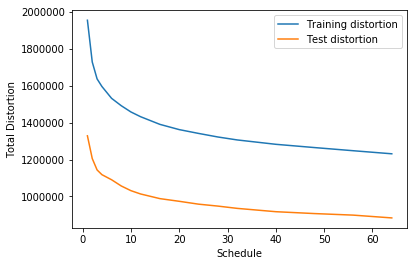

In [22]:
plt.plot(cluster_schedule, train_distortions, label='Training distortion')
plt.plot(cluster_schedule, test_distortions, label='Test distortion')
plt.xlabel("Schedule")
plt.ylabel("Total Distortion")
plt.legend()
plt.show()

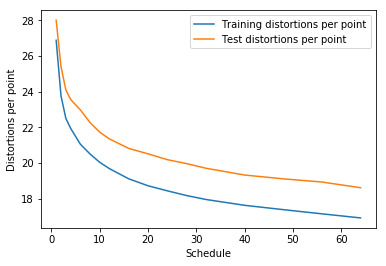

In [23]:
plt.figure(2)
plt.plot(cluster_schedule, [distortion/len(train_data) for distortion in train_distortions], label='Training distortions per point')
plt.plot(cluster_schedule, [distortion/len(test_data) for distortion in test_distortions], label='Test distortions per point')
plt.xlabel("Schedule")
plt.ylabel("Distortions per point")
plt.legend()
plt.show()